In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

In [3]:
import pandas as pd
import util.common as util
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
import pathlib
import pickle
import matplotlib.pyplot as plt

# from keras.models import Model
# from keras.layers import Dense, Input
# from keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from util.AUROCEarlyStoppingPruneCallback import AUROCEarlyStoppingPruneCallback

import neptune.new as neptune
from neptune.new.types import File

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import ThresholdPruner
import optuna.visualization as vis

## Load Data

In [4]:
train = {
    "ocsvm": {}, # 10k samples
    "ae": {}, # 100k samples
    "stage2": {}
}
val = {
    "ocsvm": {},
    "ae": {},
    "stage2": {}
}
test = {
    # "y"
    # "y_binary"
    # "y_unknown"
    # "x"
}

In [5]:
# Load Data Stage 1
clean_dir = "/project/data/cicids2017/clean/"


train["ocsvm"]["x"], train["ocsvm"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = util.load_data(clean_dir, sample_size=1948, train_size=10000, val_size=129485, test_size=56468)

val["ocsvm"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ocsvm"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))


train["ae"]["x"], train["ae"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = util.load_data(clean_dir, sample_size=1948, val_size=129485, test_size=56468)

val["ae"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ae"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2071822    195953   10000   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        63       0   
             DoS Hulk                       172726      1046       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5383        33       0   
             ALL                            321637      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

In [6]:
# Load Data Stage 2
n_benign_val = 1500

x_benign_train, _, _, _, x_benign_test, y_benign_test, x_malicious_train, y_malicious_train, x_malicious_test, y_malicious_test, attack_type_train, _, _ = util.load_data(clean_dir, sample_size=1948, train_size=n_benign_val, val_size=6815, test_size=56468)
train["stage2"]["x"], x_val, train["stage2"]["y"], y_val = train_test_split(x_malicious_train, y_malicious_train, stratify=attack_type_train, test_size=1500, random_state=42, shuffle=True)

test['x'] = np.concatenate((x_benign_test, x_malicious_test))
test["y_n"] = np.concatenate((y_benign_test, np.full(y_malicious_test.shape[0], -1)))

val["stage2"]["x"] = np.concatenate((x_val, x_benign_train))
val["stage2"]["y"] = np.concatenate((y_val, np.full(n_benign_val, "Unknown")))

train["stage2"]["y_n"] = pd.get_dummies(train["stage2"]["y"])
val["stage2"]["y_n"] = pd.get_dummies(val["stage2"]["y"])

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2071822     64783    1500   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        63       0   
             DoS Hulk                       172726      1046       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5383        33       0   
             ALL                            321637      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

In [7]:
test["y"] = np.concatenate((np.full(56468, "Benign"), y_malicious_test))
test["y_unknown"] = np.where((test["y"] == "Heartbleed") | (test["y"] == "Infiltration"), "Unknown", test["y"])
test["y_unknown_all"] = np.where(test['y_unknown'] == 'Benign', "Unknown", test['y_unknown'])

In [8]:
for k, v in train.items():
    print(k)
    print(np.unique(v['y'], return_counts=True))

ocsvm
(array([1.]), array([10000]))
ae
(array([1.]), array([100000]))
stage2
(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack'],
      dtype=object), array([1064, 1064, 1064, 1064, 1064]))


In [9]:
for k, v in val.items():
    print(k)
    print(np.unique(v['y'], return_counts=True))

ocsvm
(array([-1.,  1.]), array([  6820, 129485]))
ae
(array([-1.,  1.]), array([  6820, 129485]))
stage2
(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([ 300,  300,  300,  300, 1500,  300]))


In [10]:
for k, v in test.items():
    print(k)
    print(np.unique(v, return_counts=True))

x
(array([-1.00662376e+09, -8.38853130e+07, -8.00000000e+06, ...,
        1.03550003e+09,  1.04000000e+09,  2.07000000e+09]), array([1, 1, 3, ..., 4, 8, 6]))
y_n
(array([-1.,  1.]), array([ 2967, 56468]))
y
(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Heartbleed',
       'Infiltration', 'Port Scan', 'Web Attack'], dtype=object), array([  584, 56468,   584,   584,    11,    36,   584,   584]))
y_unknown
(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
       'Unknown', 'Web Attack'], dtype=object), array([  584, 56468,   584,   584,   584,    47,   584]))
y_unknown_all
(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([  584,   584,   584,   584, 56515,   584]))


## Scale Data

In [11]:
scaler = QuantileTransformer(output_distribution='normal')
train['ocsvm']['x_s'] = scaler.fit_transform(train['ocsvm']['x'])
val['ocsvm']['x_s'] = scaler.transform(val['ocsvm']['x'])
test['ocsvm_s'] = scaler.transform(test['x'])

In [12]:
scaler = QuantileTransformer(output_distribution='normal')
train['ae']['x_s'] = scaler.fit_transform(train['ae']['x'])
val['ae']['x_s'] = scaler.transform(val['ae']['x'])
test['ae_s'] = scaler.transform(test['x'])

In [13]:
scaler = QuantileTransformer(output_distribution='normal')
train['stage2']['x_s'] = scaler.fit_transform(train['stage2']['x'])
val['stage2']['x_s'] = scaler.transform(val['stage2']['x'])
test['stage2_s'] = scaler.transform(test['x'])

In [14]:
scaler = QuantileTransformer(output_distribution='uniform')
train['stage2']['x_q'] = scaler.fit_transform(train['stage2']['x'])
val['stage2']['x_q'] = scaler.transform(val['stage2']['x'])
test['stage2_q'] = scaler.transform(test['x'])

# Evaluate training and inference duration

In [15]:
best_ae = load_model(f'results/stage1/ae/TSM-24/models/model_530.h5')

2021-11-05 12:43:37.475964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-05 12:43:37.476012: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-05 12:43:37.476061: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-11-05 12:43:37.476432: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
%%timeit -r3 -n3 -p6
x_pred_test = best_ae.predict(test['ae_s'])
score_test = util.anomaly_scores(test['ae_s'], x_pred_test)

1.78456 s ± 16.7816 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [23]:
%%timeit -r3 -n3 -p6
best_ae.fit(
    train['ae']['x_s'],
    train['ae']['x_s'],
    epochs=7, 
    shuffle=True,
    verbose=0
)

39.6706 s ± 2.04605 s per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [15]:
f = open(f'results/stage1/ocsvm/TSM-25/models/model_193.p', 'rb')
best_ocsvm = pickle.load(f)
f.close()

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator OneClassSVM from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more i

In [25]:
%%timeit -r3 -n3 -p6
score_test = -best_ocsvm.decision_function(test['ocsvm_s'])

8.11677 s ± 276.69 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [6]:
%%timeit -r3 -n3 -p6
time.sleep(1)

1.00097 s ± 116.387 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [16]:
%%timeit -r3 -n3 -p6
best_ocsvm.fit(train['ocsvm']['x_s'])

[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
[LibSVM]*
optimization finished, #iter = 869
obj = 0.005375, rho = 0.004604
nSV = 843, nBSV = 0
777.302 ms ± 14.6253 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [17]:
%%timeit -r3 -n3 -p6
best_ocsvm.fit(train['ae']['x_s'])

[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
[LibSVM].
*..
*
optimization finished, #iter = 3591
obj = 0.227593, rho = 0.019627
nSV = 2760, nBSV = 0
4min 33s ± 204.435 ms per loop (mean ± std. dev. of 3 runs, 3 lo

In [18]:
best_nn = load_model(f'results/stage2/nn/TSM-19/models/model_522.h5')

2021-11-05 14:02:19.702050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-05 14:02:19.702103: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-05 14:02:19.702154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-11-05 14:02:19.702522: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
%%timeit -r3 -n3 -p6
y_proba_test_2 = best_nn.predict(test['stage2_q'])

2021-11-05 14:02:19.924083: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1.55515 s ± 190.155 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [33]:
%%timeit -r3 -n3 -p6
history = best_nn.fit(
        train['stage2']['x_q'],
        train["stage2"]["y_n"],
        # validation_data=(val['stage2']['x_q'], pd.get_dummies(y_val)),
        epochs=17,
        shuffle=True,
        verbose=0,
        # callbacks=[tf.keras.callbacks.EarlyStopping(
        #     monitor='val_loss', 
        #     patience=3, 
        #     min_delta=0.01, 
        #     mode='min', 
        #     restore_best_weights=True, 
        #     verbose=1
        # )]
    )

4.88506 s ± 189.491 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [15]:
f = open(f'results/stage2/rf/TSM-20/models/model_511.p', 'rb')
best_rf = pickle.load(f)
f.close()

In [16]:
%%timeit -r3 -n3 -p6
y_proba_test_2 = best_rf.predict_proba(test['stage2_s'])

609.687 ms ± 4.95458 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [18]:
%%timeit -r3 -n3 -p6
best_rf.fit(train['stage2']['x_s'], train["stage2"]["y_n"])

1.24886 s ± 34.0569 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [19]:
test['stage2_s'].shape

(59435, 67)

# Test script

In [15]:
predictions = {
    "stage1": [],
    "stage2": [],
    "y_unk": test["y_unknown"]
}

thresholds = {
    "stage1": [],
    "stage2": [],
    "extension": []
}

quantiles = [0.995, 0.99, 0.975, 0.95]

In [30]:
# Stage 1
best_runs_1 = pd.read_csv('results/stage1.csv')
val_results_1 = []
test_results_1 = []

# Iterate best models in stage 1
# for index, row in best_runs_1.iterrows():
index = 0
row = best_runs_1.iloc[index]

# Predict anomaly score on validation (sanity check) and test set
if row["algo"] == 'ae':
    model_1 = load_model(f'results/stage1/{row["algo"]}/{row["run_id"]}/models/model_{row["number"]}.h5')
    x_pred_val = model_1.predict(val['ae']['x_s'])
    score_val = util.anomaly_scores(val['ae']['x_s'], x_pred_val)
    curves_metrics, summary_metrics = util.evaluate_proba(val['ae']['y'], score_val)
    thresholds["extension"].append({q: np.quantile(score_val[val["ae"]["y"] == 1], q) for q in quantiles})
    
    x_pred_test = model_1.predict(test['ae_s'])
    score_test = util.anomaly_scores(test['ae_s'], x_pred_test)
else:
    f = open(f'results/stage1/{row["algo"]}/{row["run_id"]}/models/model_{row["number"]}.p', 'rb')
    model_1 = pickle.load(f)
    f.close()
    score_val = -model_1.decision_function(val['ocsvm']['x_s'])
    curves_metrics, summary_metrics = util.evaluate_proba(val['ocsvm']['y'], score_val)
    thresholds["extension"].append({q: np.quantile(score_val[val["ocsvm"]["y"] == 1], q) for q in quantiles})

    score_test = -model_1.decision_function(test['ocsvm_s'])
# Save predictions to dictionary
predictions['stage1'].append(score_test)
thresholds["stage1"].append({(metric, fpr): t for metric, fpr, t in zip(summary_metrics.metric, summary_metrics.FPR, summary_metrics.threshold)})

# Collect validation metrics
val_metric = {
    "algo": row["algo"],
    "run_id": row["run_id"],
    "trial_id": row["number"]
}
test_metric = val_metric.copy()
for i, row in summary_metrics.iterrows():
    val_metric[row['metric']] = row['value']
fpr, tpr, t = roc_curve(val['ae']['y'], score_val, pos_label=-1)
val_metric["AUROC"] = auc(fpr, tpr)
val_metric["au_precision_recall"] = auc(curves_metrics['recall'], curves_metrics['precision'])
val_results_1.append(val_metric)

curves_metrics_test, summary_metrics_test = util.evaluate_proba(test["y_n"], score_test)
for i, row in summary_metrics_test.iterrows():
    test_metric[row['metric']] = row['value']
fpr, tpr, t = roc_curve(test["y_n"], score_test, pos_label=-1)
test_metric["AUROC"] = auc(fpr, tpr)
test_metric["au_precision_recall"] = auc(curves_metrics_test['recall'], curves_metrics_test['precision'])
test_results_1.append(test_metric)

val_results_df = pd.DataFrame(val_results_1)
test_results_df = pd.DataFrame(test_results_1)
val_results_df

/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)


,algo,run_id,trial_id,F1,F2,F3,F4,F5,F6,F7,F8,F9,AUROC,au_precision_recall
0,ae,TSM-24,530,0.3932,0.5566,0.6578,0.7256,0.7842,0.8353,0.8701,0.8945,0.9123,0.90618,0.309476


In [31]:
test_results_df

,algo,run_id,trial_id,F1,F2,F3,F4,F5,F6,F7,F8,F9,AUROC,au_precision_recall
0,ae,TSM-24,530,0.3984,0.565,0.6666,0.7351,0.7863,0.837,0.8715,0.8958,0.9135,0.911748,0.326483


In [17]:
summary_metrics

,metric,value,threshold,precision,recall,FPR
0,F1,0.3614,1.214656,0.3328,0.3953,0.041742
1,F2,0.4828,0.058406,0.2331,0.6592,0.114222
2,F3,0.5744,-0.210442,0.1222,0.9755,0.369077
3,F4,0.6916,-0.212591,0.1219,0.9771,0.370838
4,F5,0.7696,-0.214862,0.1215,0.9784,0.372661
5,F6,0.8218,-0.214862,0.1215,0.9784,0.372661
6,F7,0.8575,-0.214862,0.1215,0.9784,0.372661
7,F8,0.8827,-0.214862,0.1215,0.9784,0.372661
8,F9,0.901,-0.216871,0.121,0.9789,0.374383


In [36]:
# Stage 2
best_runs_2 = pd.read_csv('results/stage2.csv')
val_results_2 = []
test_results_2 = []

# Iterate best models in stage 2
# for index, row in best_runs_2.iterrows():
    # Predict class probability on validation (sanity check) and test set

index = 1
row = best_runs_2.iloc[index]
    
if row['algo'] == "nn":
    model_2 = load_model(f'results/stage2/{row["algo"]}/{row["run_id"]}/models/model_{row["number"]}.h5')
    if row['scaler'] == 'normal':
        y_proba_val_2 = model_2.predict(val['stage2']['x_s'])
        y_proba_test_2 = model_2.predict(test['stage2_s']) 
    else: # 'uniform'
        y_proba_val_2 = model_2.predict(val['stage2']['x_q'])
        y_proba_test_2 = model_2.predict(test['stage2_q'])
    fmacro, fweight, threshold_fscore, f_best = util.optimal_fscore_multi(val['stage2']['y'], y_proba_val_2, train["stage2"]["y_n"].columns, start_step=0.5, stop_step=1.0)
    y_pred_val_2 = np.where(np.max(y_proba_val_2, axis=1) > f_best["f1_weighted_threshold"], train["stage2"]["y_n"].columns[np.argmax(y_proba_val_2, axis=1)], 'Unknown')
    y_pred_test_2 = np.where(np.max(y_proba_test_2, axis=1) > f_best["f1_weighted_threshold"], train["stage2"]["y_n"].columns[np.argmax(y_proba_test_2, axis=1)], 'Unknown')
else:
    f = open(f'results/stage2/{row["algo"]}/{row["run_id"]}/models/model_{row["number"]}.p', 'rb')
    model_2 = pickle.load(f)
    f.close()
    y_proba_val_2 = model_2.predict_proba(val['stage2']['x_s'])
    y_proba_test_2 = model_2.predict_proba(test['stage2_s'])
    fmacro, fweight, threshold_fscore, f_best = util.optimal_fscore_multi(val['stage2']['y'], y_proba_val_2, model_2.classes_)
    y_pred_val_2 = np.where(np.max(y_proba_val_2, axis=1) > f_best["f1_weighted_threshold"], model_2.classes_[np.argmax(y_proba_val_2, axis=1)], 'Unknown')
    y_pred_test_2 = np.where(np.max(y_proba_test_2, axis=1) > f_best["f1_weighted_threshold"], model_2.classes_[np.argmax(y_proba_test_2, axis=1)], 'Unknown')

# Collect validation metrics
val_metric = {
    "algo": row["algo"],
    "run_id": row["run_id"],
    "trial_id": row["number"]
}
test_metric = val_metric.copy()

val_metric["f1_macro"] = f_best["f1_macro"]
val_metric["f1_weighted"] = f_best["f1_weighted"]
val_metric['accuracy'] = accuracy_score(val['stage2']['y'], y_pred_val_2)
val_metric['balanced_accuracy'] = balanced_accuracy_score(val['stage2']['y'], y_pred_val_2)

test_metric["f1_macro"] = f1_score(test["y_unknown_all"], y_pred_test_2, average='macro')
test_metric["f1_weighted"] = f1_score(test["y_unknown_all"], y_pred_test_2, average='weighted')
test_metric['accuracy'] = accuracy_score(test["y_unknown_all"], y_pred_test_2)
test_metric['balanced_accuracy'] = balanced_accuracy_score(test["y_unknown_all"], y_pred_test_2)


# Save predictions to dictionary
predictions['stage2'].append(y_proba_test_2)
thresholds["stage2"].append(f_best['f1_weighted_threshold'])
val_results_2.append(val_metric)
test_results_2.append(test_metric)

val_results_df_2 = pd.DataFrame(val_results_2)
test_results_df_2 = pd.DataFrame(test_results_2)
val_results_df_2

,algo,run_id,trial_id,f1_macro,f1_weighted,accuracy,balanced_accuracy
0,rf,TSM-20,488,0.973034,0.973067,0.973,0.970111


In [37]:
test_results_df_2

,algo,run_id,trial_id,f1_macro,f1_weighted,accuracy,balanced_accuracy
0,rf,TSM-20,488,0.873156,0.982193,0.979322,0.972086


In [19]:
thresholds

{'stage1': [{('F1', 0.041742286751361164): 1.2146557225714867,
   ('F2', 0.11422172452407615): 0.05840613281788709,
   ('F3', 0.36907749932424605): -0.21044237238546426,
   ('F4', 0.37083832104104725): -0.21259066614208466,
   ('F5', 0.37266092597598177): -0.21486187734700035,
   ('F6', 0.37266092597598177): -0.21486187734700035,
   ('F7', 0.37266092597598177): -0.21486187734700035,
   ('F8', 0.37266092597598177): -0.21486187734700035,
   ('F9', 0.3743831331814496): -0.2168708513115285}],
 'stage2': [0.9500000000000001],
 'extension': [{0.995: 3.0374480057125925,
   0.99: 2.8507913803515916,
   0.975: 2.05709789864454,
   0.95: 0.928822765485915}]}

In [1]:
import pickle

In [3]:
f = open("results/thresholds.pkl","rb")
thresholds = pickle.load(f)
f.close()

In [4]:
thresholds

{'stage1': [{('F1', 0.11236050507780825): 0.6728233733163492,
   ('F2', 0.12725798355021817): 0.6369365755972735,
   ('F3', 0.12750511642275167): 0.6360641262944802,
   ('F4', 0.19139668687492759): 0.5097518208500721,
   ('F5', 0.35494458817623664): 0.38938147940627515,
   ('F6', 0.35494458817623664): 0.38938147940627515,
   ('F7', 0.35494458817623664): 0.38938147940627515,
   ('F8', 0.35494458817623664): 0.38938147940627515,
   ('F9', 0.35696798857010464): 0.3880964082936597},
  {('F1', 0.03421245704135614): 1.4884871379603133,
   ('F2', 0.16187975441170793): 0.6966754750168122,
   ('F3', 0.16384909448970925): 0.6946786975131792,
   ('F4', 0.1671467737575781): 0.6912034237822515,
   ('F5', 0.1671467737575781): 0.6912034237822515,
   ('F6', 0.20758389002587171): 0.6410247069497987,
   ('F7', 0.4833841757732556): 0.3358561000712622,
   ('F8', 0.4833841757732556): 0.3358561000712622,
   ('F9', 0.4833841757732556): 0.3358561000712622},
  {('F1', 0.018936556357879292): 3.2706238529004774,


In [20]:
predictions

{'stage1': [array([-0.12840111, -0.19766945, -0.69285544, ...,  0.06216901,
          2.76551358,  1.29552452])],
 'stage2': [array([[0.58530617, 0.3046808 , 0.06646189, 0.02229097, 0.02126015],
         [0.02075771, 0.00676965, 0.19468199, 0.01115415, 0.7666365 ],
         [0.05763403, 0.88100195, 0.01128945, 0.03917179, 0.01090274],
         ...,
         [0.00830957, 0.97208065, 0.00752776, 0.00638217, 0.00569984],
         [0.97742623, 0.00869735, 0.00404776, 0.00274534, 0.00708334],
         [0.00641845, 0.00795202, 0.00906782, 0.97245365, 0.00410806]],
        dtype=float32)],
 'y_unk': array(['Benign', 'Benign', 'Benign', ..., 'Botnet', '(D)DOS', 'Port Scan'],
       dtype=object)}

In [21]:
for (metric, fpr), threshold_b in thresholds["stage1"][0].items():
    print(metric, fpr, threshold_b)

F1 0.041742286751361164 1.2146557225714867
F2 0.11422172452407615 0.05840613281788709
F3 0.36907749932424605 -0.21044237238546426
F4 0.37083832104104725 -0.21259066614208466
F5 0.37266092597598177 -0.21486187734700035
F6 0.37266092597598177 -0.21486187734700035
F7 0.37266092597598177 -0.21486187734700035
F8 0.37266092597598177 -0.21486187734700035
F9 0.3743831331814496 -0.2168708513115285


In [22]:
for index_1, y_proba_1 in enumerate(predictions["stage1"]):
    print(index_1)

0


In [23]:
# Combine Stage 1 and Stage 2 for full model performance

results_test = {
    "stage1": {},
    "stage2": {},
    "extension": {},
    "full_model": {}
}
                                
for index_1, y_proba_1 in enumerate(predictions["stage1"]):
    for (metric, fpr), threshold_b in thresholds["stage1"][index_1].items():
        y_pred_1 = np.where(y_proba_1 < threshold_b, "Benign", "Fraud")
        results_test['stage1'][(index_1, metric)] = y_pred_1
        y_pred = y_pred_1.astype(object).copy()
        for index_2, y_proba_2 in enumerate(predictions['stage2']):
            threshold_m = thresholds["stage2"][index_2]
            y_pred_2 = np.where(np.max(y_proba_2[y_pred_1 == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred_1 == "Fraud"], axis=1)], 'Unknown')
            results_test['stage2'][(index_1, metric, index_2)] = y_pred_2
            y_pred[y_pred_1 == "Fraud"] = y_pred_2
            for quantile, threshold_u in thresholds["extension"][index_1].items():
                y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
                results_test['extension'][(index_1, metric, index_2, quantile)] = y_pred_3
                y_pred[y_pred == "Unknown"] = y_pred_3
                results_test['full_model'][(index_1, metric, index_2, quantile)] = y_pred

In [24]:
for i, y in results_test['stage1'].items():
    print(i, np.unique(y, return_counts=True))

(0, 'F1') (array(['Benign', 'Fraud'], dtype='<U6'), array([55910,  3525]))
(0, 'F2') (array(['Benign', 'Fraud'], dtype='<U6'), array([51109,  8326]))
(0, 'F3') (array(['Benign', 'Fraud'], dtype='<U6'), array([35692, 23743]))
(0, 'F4') (array(['Benign', 'Fraud'], dtype='<U6'), array([35602, 23833]))
(0, 'F5') (array(['Benign', 'Fraud'], dtype='<U6'), array([35505, 23930]))
(0, 'F6') (array(['Benign', 'Fraud'], dtype='<U6'), array([35505, 23930]))
(0, 'F7') (array(['Benign', 'Fraud'], dtype='<U6'), array([35505, 23930]))
(0, 'F8') (array(['Benign', 'Fraud'], dtype='<U6'), array([35505, 23930]))
(0, 'F9') (array(['Benign', 'Fraud'], dtype='<U6'), array([35424, 24011]))


In [25]:
for i, y in results_test['stage2'].items():
    print(i, np.unique(y, return_counts=True))

(0, 'F1', 0) (array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([ 846,  210,  107,  607, 1725,   30]))
(0, 'F2', 0) (array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([1277,  633,  769,  623, 4992,   32]))
(0, 'F3', 0) (array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([ 1734,  2585,  1334,   676, 16707,   707]))
(0, 'F4', 0) (array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([ 1739,  2587,  1337,   676, 16782,   712]))
(0, 'F5', 0) (array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([ 1740,  2593,  1348,   676, 16854,   719]))
(0, 'F6', 0) (array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
       'Web Attack'], dtype=object), array([ 1740,  2593,  1348,   676, 16854,   719]))
(0, 

In [26]:
for i, y in results_test['extension'].items():
    print(i, np.unique(y, return_counts=True))

(0, 'F1', 0, 0.995) (array(['Benign', 'Unknown'], dtype='<U7'), array([1505,  220]))
(0, 'F1', 0, 0.99) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F1', 0, 0.975) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F1', 0, 0.95) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F2', 0, 0.995) (array(['Benign', 'Unknown'], dtype='<U7'), array([4772,  220]))
(0, 'F2', 0, 0.99) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F2', 0, 0.975) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F2', 0, 0.95) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F3', 0, 0.995) (array(['Benign', 'Unknown'], dtype='<U7'), array([16487,   220]))
(0, 'F3', 0, 0.99) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F3', 0, 0.975) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F3', 0, 0.95) (array(['Unknown'], dtype='<U7'), array([220]))
(0, 'F4', 0, 0.995) (array(['Benign', 'Unknown'], dtype='<U7'), array([16562,   220]))
(0, 'F4', 0, 0.99) (array(['Unknown'], dtype='<U7'

In [27]:
for i, y in results_test['full_model'].items():
    print(i, np.unique(y, return_counts=True))

(0, 'F1', 0, 0.995) (array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
       'Unknown', 'Web Attack'], dtype=object), array([  846, 57415,   210,   107,   607,   220,    30]))
(0, 'F1', 0, 0.99) (array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
       'Unknown', 'Web Attack'], dtype=object), array([  846, 57415,   210,   107,   607,   220,    30]))
(0, 'F1', 0, 0.975) (array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
       'Unknown', 'Web Attack'], dtype=object), array([  846, 57415,   210,   107,   607,   220,    30]))
(0, 'F1', 0, 0.95) (array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
       'Unknown', 'Web Attack'], dtype=object), array([  846, 57415,   210,   107,   607,   220,    30]))
(0, 'F2', 0, 0.995) (array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
       'Unknown', 'Web Attack'], dtype=object), array([ 1277, 55881,   633,   769,   623,   220,    32]))
(0, 'F2', 0, 0.99) (array(['(D)DOS', 'Beni

# Generate Graphs

In [17]:
index_1 = 0

In [15]:
# write predictions and thresholds to disk
f = open("results/predictions.pkl","rb")
predictions = pickle.load(f)
f.close()
f = open("results/thresholds.pkl","rb")
thresholds = pickle.load(f)
f.close()

In [18]:
thresholds["stage1"][index_1]

{('F1', 0.11236050507780825): 0.6728234528091783,
 ('F2', 0.12725798355021817): 0.636936704220479,
 ('F3', 0.12750511642275167): 0.6360641559762945,
 ('F4', 0.19139668687492759): 0.509751909008626,
 ('F5', 0.35494458817623664): 0.3893812768920822,
 ('F6', 0.35494458817623664): 0.3893812768920822,
 ('F7', 0.35494458817623664): 0.3893812768920822,
 ('F8', 0.35494458817623664): 0.3893812768920822,
 ('F9', 0.35696798857010464): 0.3880964725534804}

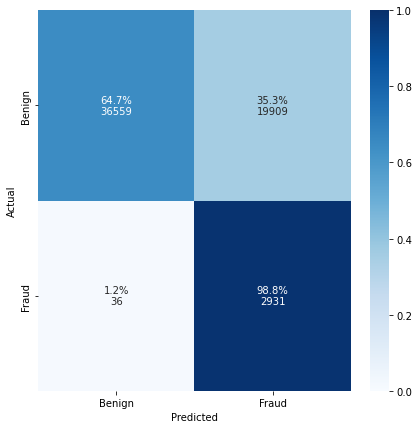

In [19]:
index_1 = 0
y_proba_1 = predictions["stage1"][index_1]
threshold_b = 0.3880964082936597

y_pred = np.where(y_proba_1 < threshold_b, 1, -1)
y_pred_1 = np.where(y_proba_1 < threshold_b, "Benign", "Fraud")
fig = util.plot_confusion_matrix(test['y_n'], y_pred, values=[1, -1], labels=["Benign", "Fraud"])

In [20]:
index_2 = 0
y_proba_2 = predictions['stage2'][index_2]
threshold_m = thresholds["stage2"][index_2]
classes_2 = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']

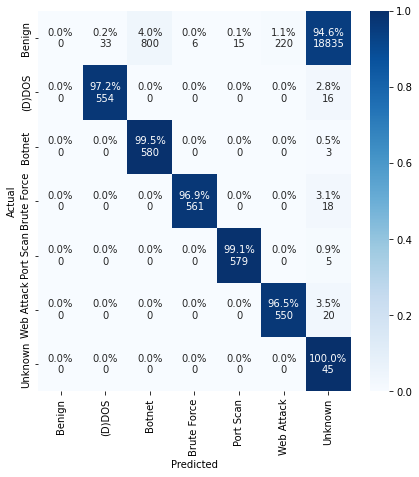

In [21]:
y_pred_2 = np.where(np.max(y_proba_2[y_pred_1 == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred_1 == "Fraud"], axis=1)], 'Unknown')
fig = util.plot_confusion_matrix(test['y_unknown'][y_pred_1 == "Fraud"], y_pred_2, values=classes_2, labels=classes_2)

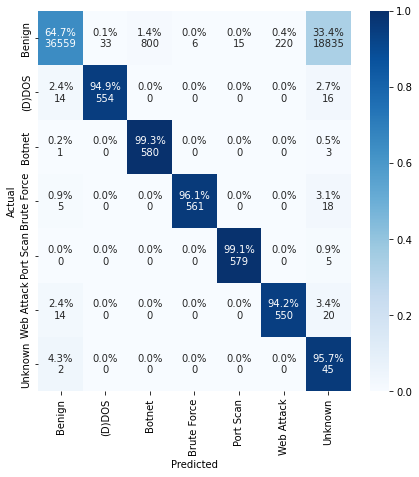

In [22]:
y_pred = y_pred_1.astype(object).copy()
y_pred[y_pred_1 == "Fraud"] = y_pred_2
fig = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes_2, labels=classes_2)

In [23]:
thresholds["extension"][index_1]

{0.995: 5.426480844370544,
 0.99: 3.1662122751717767,
 0.975: 1.6697223029442627,
 0.95: 1.0918603134656644}

In [24]:
threshold_u = 5.426480885093732

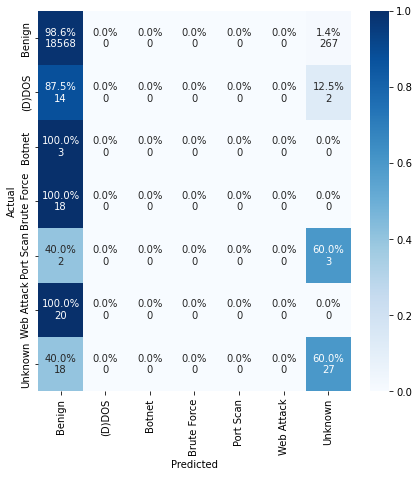

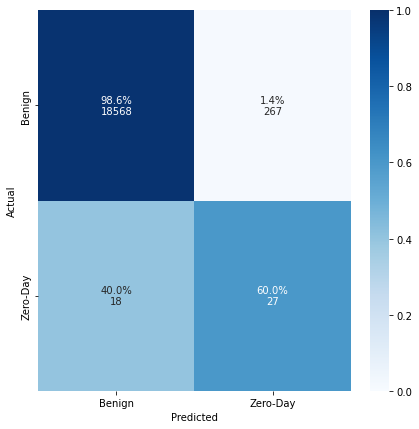

In [25]:
mask = ((y_pred == "Unknown") & (test['y_unknown_all'] == "Unknown"))
y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
y_pred_3_n = np.where(y_proba_1[mask] < threshold_u, 1, -1)
confusion_3_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Unknown"], y_pred_3, values=classes_2, labels=classes_2)
confusion_3_binary = util.plot_confusion_matrix(test['y_n'][mask], y_pred_3_n, values=[1, -1], labels=["Benign", "Zero-Day"])

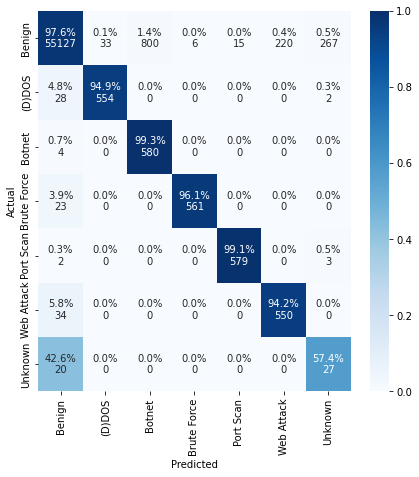

In [26]:
y_pred[y_pred == "Unknown"] = y_pred_3
fig = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes_2, labels=classes_2)

In [ ]:
# Combine Stage 1 and Stage 2 for full model performance

results_test = {
    "stage1": {},
    "stage2": {},
    "extension": {},
    "full_model": {}
}

results_12 = []
results_123 = []

classes_2 = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
                                
for index_1, y_proba_1 in enumerate(predictions["stage1"]):
    for (metric, fpr), threshold_b in thresholds["stage1"][index_1].items():
        y_pred_1_n = np.where(y_proba_1 < threshold_b, 1, -1)
        confusion_1_binary = util.plot_confusion_matrix(test['y_n'], y_pred_1_n, values=[1, -1], labels=["Benign", "Fraud"])
        y_pred_1 = np.where(y_proba_1 < threshold_b, "Benign", "Fraud")
        results_test['stage1'][(index_1, metric)] = y_pred_1
        y_pred = y_pred_1.astype(object).copy()
        for index_2, y_proba_2 in enumerate(predictions['stage2']):
            threshold_m = thresholds["stage2"][index_2]
            y_pred_2 = np.where(np.max(y_proba_2[y_pred_1 == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred_1 == "Fraud"], axis=1)], 'Unknown')
            confusion_2_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred_1 == "Fraud"], y_pred_2, values=classes_2, labels=classes_2)
            
            results_test['stage2'][(index_1, metric, index_2)] = y_pred_2
            y_pred[y_pred_1 == "Fraud"] = y_pred_2
            result_12 = {
                "index_1": index_1,
                "threshold_b_fpr": fpr,
                "threshold_b_metric": metric,
                "index_2": index_2,
                "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
                "ACC": accuracy_score(test['y_unknown'], y_pred),
                "f1_micro" f1_score(test['y_unknown'], y_pred, average='micro'),
                "f1_macro" f1_score(test['y_unknown'], y_pred, average='macro'),
                "f1_weighted" f1_score(test['y_unknown'], y_pred, average='weighted')
            }
            results_12.append(result_12)
            confusion_12_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes_2, labels=classes_2)
            mask = ((y_pred == "Unknown") & (test['y_unknown_all'] == "Unknown"))
            for quantile, threshold_u in thresholds["extension"][index_1].items():
                y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
                y_pred_3_n = np.where(y_proba_1[mask] < threshold_u, 1, -1)
                confusion_3_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Unknown"], y_pred_3, values=classes_2, labels=classes_2)
                confusion_3_binary = util.plot_confusion_matrix(test['y_n'][mask], y_pred_3_n, values=[1, -1], labels=["Benign", "Zero-Day"])
                results_test['extension'][(index_1, metric, index_2, quantile)] = y_pred_3
                
                y_pred[y_pred == "Unknown"] = y_pred_3
                result_123 = {
                    "index_1": index_1,
                    "threshold_b_fpr": fpr,
                    "threshold_b_metric": metric,
                    "index_2": index_2,
                    "quantile": quantile,
                    "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
                    "ACC": accuracy_score(test['y_unknown'], y_pred),
                    "f1_micro" f1_score(test['y_unknown'], y_pred, average='micro'),
                    "f1_macro" f1_score(test['y_unknown'], y_pred, average='macro'),
                    "f1_weighted" f1_score(test['y_unknown'], y_pred, average='weighted')
                }
                results_123.append(result_123)
                confusion_123_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes_2, labels=classes_2)
                results_test['full_model'][(index_1, metric, index_2, quantile)] = y_pred
    
        plt.close('all')

    
# Save metrics on disk
df = pd.DataFrame(results_12)
df.to_csv("results/results_12.csv", index=False)
df = pd.DataFrame(results_123)
df.to_csv("results/results_123.csv", index=False)

# Graphs

In [29]:
df_123.sort_values(by="f1_weighted", inplace=True, ascending=False)
df_123.head(3)

,index_1,threshold_b_fpr,threshold_b_metric,index_2,quantile,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
3756,3,0.312492,F5,9,0.995,0.895412,0.98765,0.98765,0.827638,0.989726,0.595745,6.234043
3876,3,0.312492,F6,9,0.995,0.895412,0.98765,0.98765,0.827638,0.989726,0.595745,6.234043
4116,3,0.312492,F8,9,0.995,0.895412,0.98765,0.98765,0.827638,0.989726,0.595745,6.234043


In [48]:
df_123 = pd.read_csv("results/results_123.csv")
df_123.sort_values(by="f1_weighted", inplace=True, ascending=False)
df_123[df_123.zero_day_recall_extension > 0.7].head(10)

,index_1,threshold_b_fpr,threshold_b_metric,index_2,quantile,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
4117,3,0.312492,F8,9,0.99,0.934248,0.983360,0.983360,0.823098,0.987539,0.872340,12.212766
3877,3,0.312492,F6,9,0.99,0.934248,0.983360,0.983360,0.823098,0.987539,0.872340,12.212766
3997,3,0.312492,F7,9,0.99,0.934248,0.983360,0.983360,0.823098,0.987539,0.872340,12.212766
3757,3,0.312492,F5,9,0.99,0.934248,0.983360,0.983360,0.823098,0.987539,0.872340,12.212766
20797,19,0.317851,F3,9,0.99,0.926374,0.983394,0.983394,0.820364,0.987358,0.851064,11.744681
20917,19,0.322362,F4,9,0.99,0.928762,0.983175,0.983175,0.819734,0.987204,0.851064,11.744681
21037,19,0.323219,F5,9,0.99,0.929001,0.983158,0.983158,0.819704,0.987193,0.851064,11.744681
21157,19,0.326447,F6,9,0.99,0.929702,0.982990,0.982990,0.819024,0.987061,0.851064,11.744681
21397,19,0.326447,F8,9,0.99,0.929702,0.982990,0.982990,0.819024,0.987061,0.851064,11.744681
21277,19,0.326447,F7,9,0.99,0.929702,0.982990,0.982990,0.819024,0.987061,0.851064,11.744681


In [52]:
df_123[(df_123.index_1 == 3) & (df_123.threshold_b_metric == 'F9') & (df_123.zero_day_recall_extension > 0.7)].head(10)

,index_1,threshold_b_fpr,threshold_b_metric,index_2,quantile,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
4237,3,0.420867,F9,9,0.99,0.947842,0.977168,0.977168,0.801503,0.982924,0.87234,12.212766
4225,3,0.420867,F9,6,0.99,0.950159,0.976479,0.976479,0.797923,0.982309,0.87234,12.127660
4205,3,0.420867,F9,1,0.99,0.953527,0.973113,0.973113,0.776241,0.979022,0.87234,12.085106
4201,3,0.420867,F9,0,0.99,0.953965,0.972811,0.972811,0.777604,0.979011,0.87234,12.191489
4209,3,0.420867,F9,2,0.99,0.953007,0.972878,0.972878,0.776595,0.978987,0.87234,12.191489
4213,3,0.420867,F9,3,0.99,0.953968,0.972827,0.972827,0.774737,0.978817,0.87234,12.127660
4221,3,0.420867,F9,5,0.99,0.953703,0.972676,0.972676,0.774764,0.978742,0.87234,12.127660
4233,3,0.420867,F9,8,0.99,0.952001,0.972626,0.972626,0.773751,0.978654,0.87234,12.191489
4217,3,0.420867,F9,4,0.99,0.954219,0.971280,0.971280,0.766678,0.977470,0.87234,12.191489
4229,3,0.420867,F9,7,0.99,0.953775,0.969934,0.969934,0.760835,0.976398,0.87234,12.127660


,index_1,threshold_b,index_2,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,3,-0.00022,9,0.98,-,0.909740,0.699184,0.699184,0.779970,0.818229,-,-
1,3,-0.00022,9,0.98,0.004059,0.934248,0.983360,0.983360,0.823098,0.987539,0.87234,12.212766


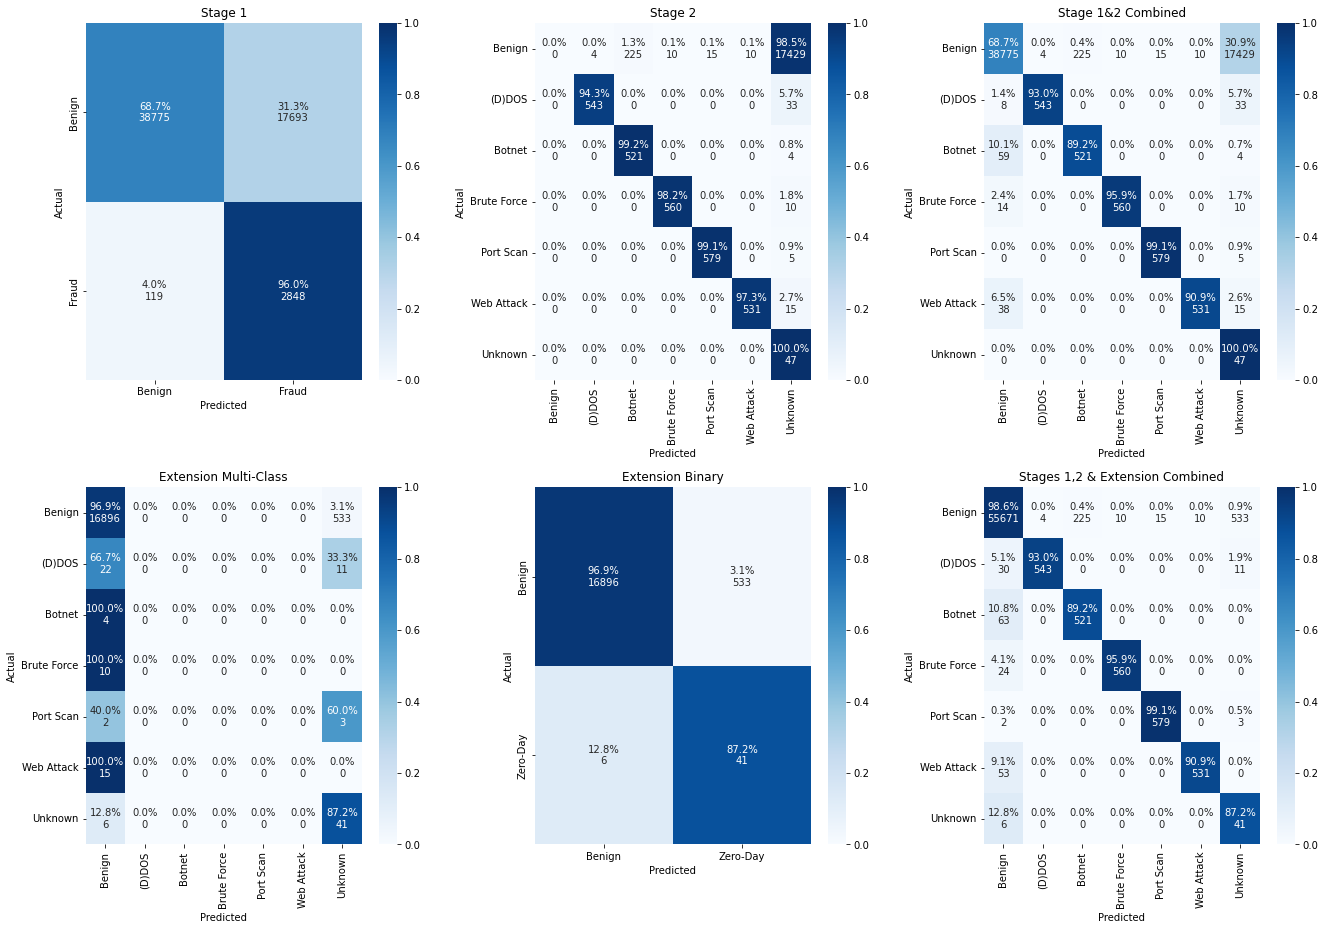

In [28]:
# Max f1(_weighted) (or ACC) with zero_day recall > 70%
generateConfusionGraphs(3, -0.0002196942507948895, 9, 0.98, 0.0040588613744241275, True)

In [35]:
plt.savefig("test.png")

<Figure size 432x288 with 0 Axes>

,index_1,threshold_b,index_2,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,3,-0.00022,9,0.98,-,0.909740,0.699184,0.699184,0.779970,0.818229,-,-
1,3,-0.00022,9,0.98,0.004059,0.934248,0.983360,0.983360,0.823098,0.987539,0.87234,12.212766


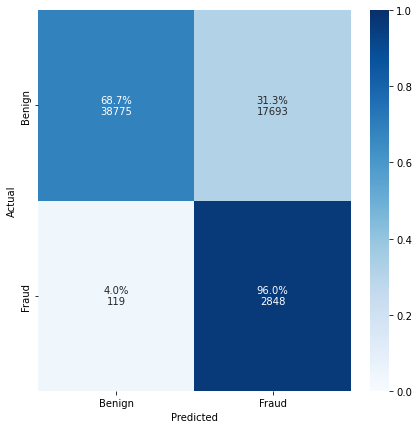

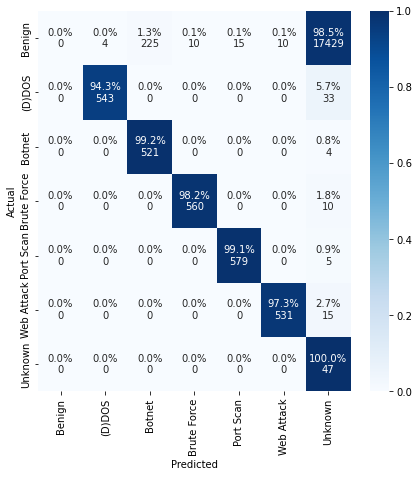

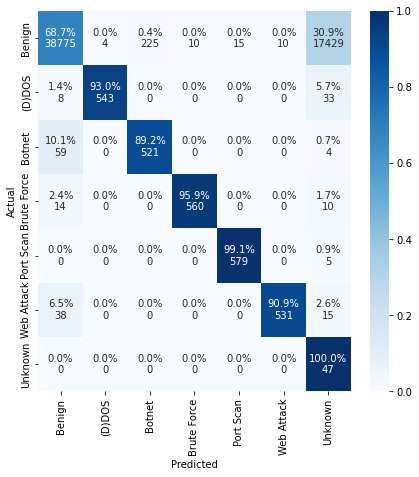

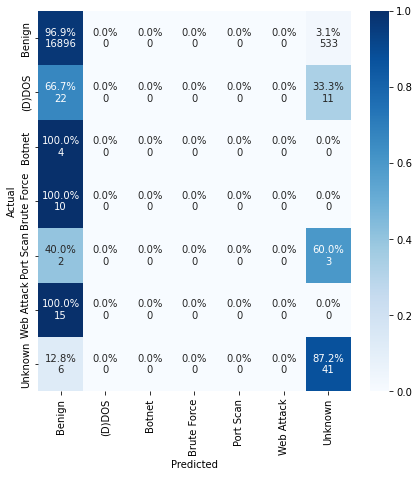

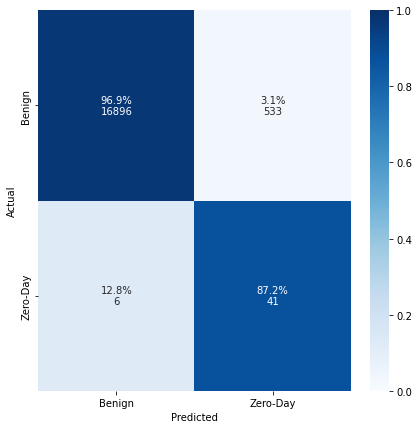

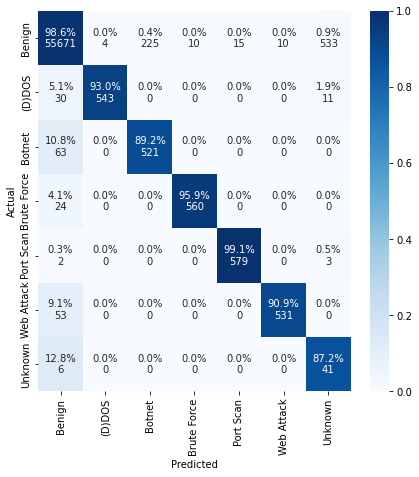

In [37]:
# Max f1(_weighted) (or ACC) with zero_day recall > 70%
generateConfusionGraphsSave(3, -0.0002196942507948895, 9, 0.98, 0.0040588613744241275, True)

,index_1,threshold_b,index_2,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,3,-0.00022,18,0.95,-,0.852504,0.696593,0.696593,0.616645,0.806998,-,-
1,3,-0.00022,18,0.95,0.004059,0.875275,0.949020,0.949020,0.656691,0.958849,0.875,10.170213


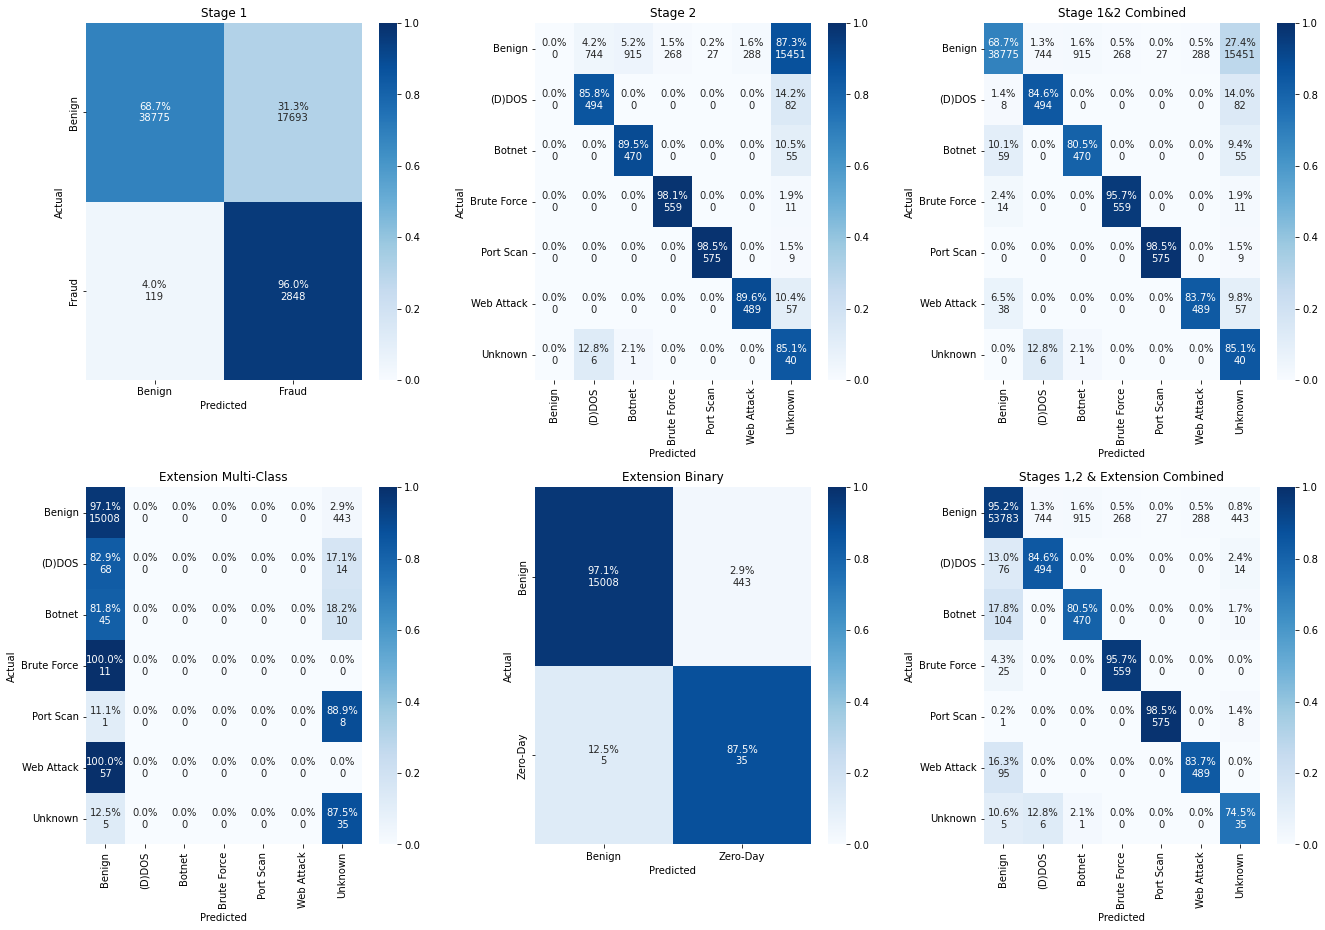

In [22]:
# NN as model in stage 2 (low macro F1 score analysis)
generateConfusionGraphs(3, -0.0002196942507948895, 18, 0.95, 0.0040588613744241275, True)

,index_1,threshold_b,index_2,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,0,0.389381,9,0.98,-,0.913545,0.665063,0.665063,0.750969,0.791912,-,-
1,0,0.389381,9,0.98,3.166212,0.941992,0.975435,0.975435,0.796292,0.981733,0.866667,12.319149


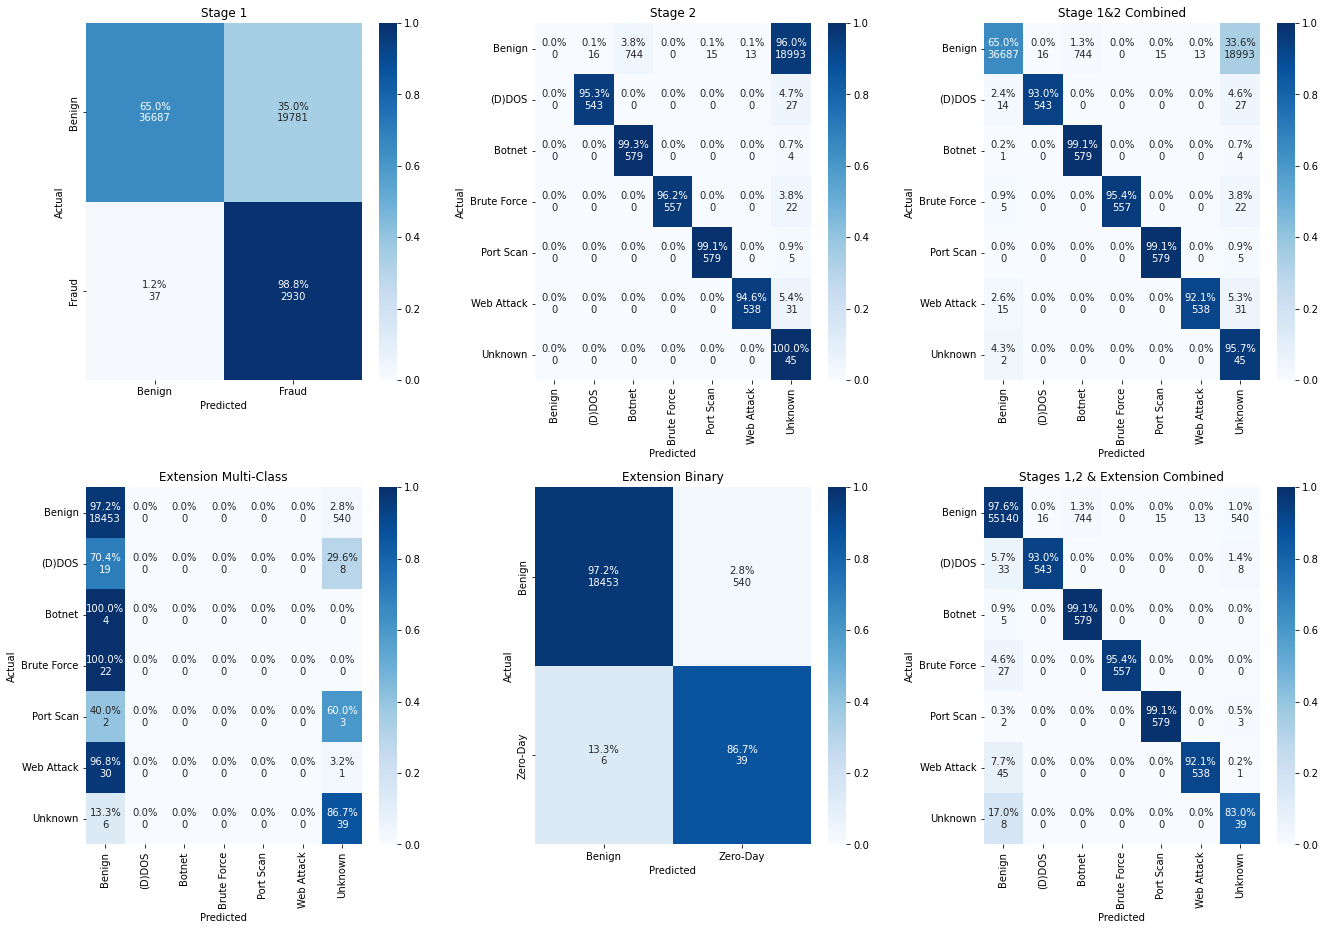

In [27]:
# AE as model in stage 1 (worse overall performance even AE is superior in stage1)
generateConfusionGraphs(0, 0.3893812768920822, 9, 0.98, 3.1662122751717767, True)

In [23]:
index_1 = 0
thresholds['stage1'][index_1]

{('F1', 0.11236050507780825): 0.6728234528091783,
 ('F2', 0.12725798355021817): 0.636936704220479,
 ('F3', 0.12750511642275167): 0.6360641559762945,
 ('F4', 0.19139668687492759): 0.509751909008626,
 ('F5', 0.35494458817623664): 0.3893812768920822,
 ('F6', 0.35494458817623664): 0.3893812768920822,
 ('F7', 0.35494458817623664): 0.3893812768920822,
 ('F8', 0.35494458817623664): 0.3893812768920822,
 ('F9', 0.35696798857010464): 0.3880964725534804}

In [24]:
index_2 = 9
thresholds['stage2'][index_2]

0.98

In [25]:
thresholds['extension'][index_1]

{0.995: 5.426480844370544,
 0.99: 3.1662122751717767,
 0.975: 1.6697223029442627,
 0.95: 1.0918603134656644}

,index_1,threshold_b,index_2,threshold_m,threshold_u,bACC,ACC,f1_micro,f1_macro,f1_weighted,zero_day_recall_extension,zero_day_recall_total
0,3,-0.00022,9,0.98,-,0.909740,0.699184,0.699184,0.779970,0.818229,-,-
1,3,-0.00022,9,0.98,0.00453,0.895412,0.987650,0.987650,0.827638,0.989726,0.595745,6.234043


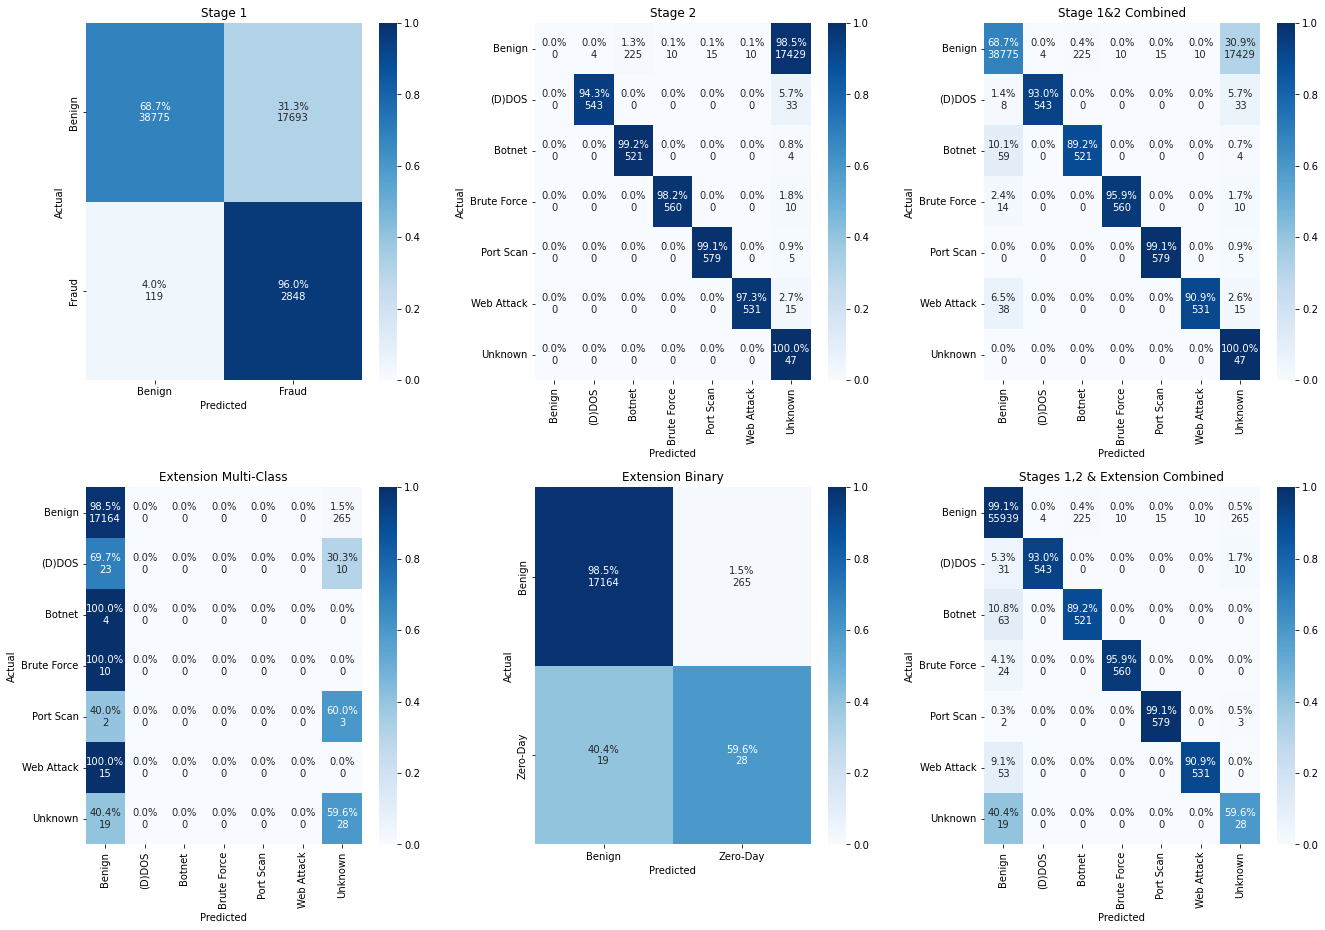

In [127]:
generateConfusionGraphs(3, -0.0002196942507948895, 9, 0.98, 0.004530129828299084, True)

In [21]:
def generateConfusionGraphs(index_1, threshold_b, index_2, threshold_m, threshold_u, include_metrics=False):
    fig, axs = plt.subplots(2,3, figsize=(18,12))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.3)
    y_proba_1 = predictions["stage1"][index_1]
    metrics = []
    classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
    
    y_pred_1_n = np.where(y_proba_1 < threshold_b, 1, -1)
    confusion_1_binary = util.plot_confusion_matrix(test['y_n'], y_pred_1_n, values=[1, -1], labels=["Benign", "Fraud"], title="Stage 1", ax=axs[0, 0])
    y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud")
    
    y_proba_2 = predictions['stage2'][index_2]
    y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
    confusion_2_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Fraud"], y_pred_2, values=classes, labels=classes, title="Stage 2", ax=axs[0, 1])

    y_pred = y_pred.astype(object)
    y_pred[y_pred == "Fraud"] = y_pred_2
    if include_metrics:
        result_12 = {
            "index_1": index_1,
            "threshold_b": threshold_b,
            "index_2": index_2,
            "threshold_m": threshold_m,
            "threshold_u": "-",
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": "-",
            "zero_day_recall_total": "-"
        }
        metrics.append(result_12)
    confusion_12_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes, title="Stage 1&2 Combined", ax=axs[0, 2])
    mask = ((y_pred == "Unknown") & (test['y_unknown_all'] == "Unknown"))
    
    y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
    y_pred_3_n = np.where(y_proba_1[mask] < threshold_u, 1, -1)
    confusion_3_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Unknown"], y_pred_3, values=classes, labels=classes, title="Extension Multi-Class", ax=axs[1, 0])
    confusion_3_binary = util.plot_confusion_matrix(test['y_n'][mask], y_pred_3_n, values=[1, -1], labels=["Benign", "Zero-Day"], title="Extension Binary", ax=axs[1, 1])

    y_pred[y_pred == "Unknown"] = y_pred_3
    if include_metrics:
        result_123 = {
            "index_1": index_1,
            "threshold_b": threshold_b,
            "index_2": index_2,
            "threshold_m": threshold_m,
            "threshold_u": threshold_u,
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": recall_score(test['y_n'][mask], y_pred_3_n, pos_label=-1),
            "zero_day_recall_total": (y_pred_3_n == -1).sum() / 47
        }
        metrics.append(result_123)
    confusion_123_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes, title="Stages 1,2 & Extension Combined", ax=axs[1, 2])
    return pd.DataFrame(metrics)

In [36]:
def generateConfusionGraphsSave(index_1, threshold_b, index_2, threshold_m, threshold_u, include_metrics=False):
    y_proba_1 = predictions["stage1"][index_1]
    metrics = []
    classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
    
    y_pred_1_n = np.where(y_proba_1 < threshold_b, 1, -1)
    confusion_1_binary = util.plot_confusion_matrix(test['y_n'], y_pred_1_n, values=[1, -1], labels=["Benign", "Fraud"])
    plt.savefig('confusion_1_binary.eps', bbox_inches='tight')
    y_pred = np.where(y_proba_1 < threshold_b, "Benign", "Fraud")
    
    y_proba_2 = predictions['stage2'][index_2]
    y_pred_2 = np.where(np.max(y_proba_2[y_pred == "Fraud"], axis=1) > threshold_m, train["stage2"]["y_n"].columns[np.argmax(y_proba_2[y_pred == "Fraud"], axis=1)], 'Unknown')
    confusion_2_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Fraud"], y_pred_2, values=classes, labels=classes)
    plt.savefig('confusion_2_multi.eps', bbox_inches='tight')

    y_pred = y_pred.astype(object)
    y_pred[y_pred == "Fraud"] = y_pred_2
    if include_metrics:
        result_12 = {
            "index_1": index_1,
            "threshold_b": threshold_b,
            "index_2": index_2,
            "threshold_m": threshold_m,
            "threshold_u": "-",
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": "-",
            "zero_day_recall_total": "-"
        }
        metrics.append(result_12)
    confusion_12_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)
    plt.savefig('confusion_12.eps', bbox_inches='tight')
    mask = ((y_pred == "Unknown") & (test['y_unknown_all'] == "Unknown"))
    
    y_pred_3 = np.where(y_proba_1[y_pred == "Unknown"] < threshold_u, "Benign", "Unknown")
    y_pred_3_n = np.where(y_proba_1[mask] < threshold_u, 1, -1)
    confusion_3_multi = util.plot_confusion_matrix(test['y_unknown'][y_pred == "Unknown"], y_pred_3, values=classes, labels=classes)
    plt.savefig('confusion_3_multi.eps', bbox_inches='tight')
    confusion_3_binary = util.plot_confusion_matrix(test['y_n'][mask], y_pred_3_n, values=[1, -1], labels=["Benign", "Zero-Day"])
    plt.savefig('confusion_3_binary.eps', bbox_inches='tight')

    y_pred[y_pred == "Unknown"] = y_pred_3
    if include_metrics:
        result_123 = {
            "index_1": index_1,
            "threshold_b": threshold_b,
            "index_2": index_2,
            "threshold_m": threshold_m,
            "threshold_u": threshold_u,
            "bACC": balanced_accuracy_score(test['y_unknown'], y_pred),
            "ACC": accuracy_score(test['y_unknown'], y_pred),
            "f1_micro": f1_score(test['y_unknown'], y_pred, average='micro'),
            "f1_macro": f1_score(test['y_unknown'], y_pred, average='macro'),
            "f1_weighted": f1_score(test['y_unknown'], y_pred, average='weighted'),
            "zero_day_recall_extension": recall_score(test['y_n'][mask], y_pred_3_n, pos_label=-1),
            "zero_day_recall_total": (y_pred_3_n == -1).sum() / 47
        }
        metrics.append(result_123)
    confusion_123_multi = util.plot_confusion_matrix(test['y_unknown'], y_pred, values=classes, labels=classes)
    plt.savefig('confusion_123.eps', bbox_inches='tight')
    return pd.DataFrame(metrics)

In [132]:
y_proba_1

array([0.17121143, 0.42366324, 0.11452468, ..., 0.46246926, 2.81566137,
       2.33414891])

# Stage 1: Load Model

In [15]:
best_runs_1 = pd.read_csv('results/stage1.csv')
best_runs_1

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_gamma,params_n_comp,params_nu,user_attrs_AUROC,...,run_id,params_encoder_layers,params_l2,params_n_layer_0,params_n_layer_1,params_n_layer_2,params_n_layer_3,params_n_layer_4,params_n_layer_5,user_attrs_epochs
0,530,530,0.906180,2021-08-03 03:59:09.291371,2021-08-03 04:00:23.358461,0 days 00:01:14.067090,NaN,NaN,NaN,0.906180,...,TSM-24,1.0,0.000025,42.0,NaN,NaN,NaN,NaN,NaN,7.0
1,635,635,0.894307,2021-08-03 06:26:09.695672,2021-08-03 06:27:39.039174,0 days 00:01:29.343502,NaN,NaN,NaN,0.894307,...,TSM-24,1.0,0.000018,41.0,NaN,NaN,NaN,NaN,NaN,7.0
2,661,661,0.893361,2021-08-03 07:02:39.903359,2021-08-03 07:03:48.894886,0 days 00:01:08.991527,NaN,NaN,NaN,0.893361,...,TSM-24,1.0,0.000099,37.0,NaN,NaN,NaN,NaN,NaN,7.0
3,193,193,0.893079,2021-08-02 17:55:03.038946,2021-08-02 17:55:20.847417,0 days 00:00:17.808471,0.063265,56.0,0.000232,0.893079,...,TSM-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,600,600,0.891181,2021-08-03 05:32:44.015750,2021-08-03 05:34:12.500152,0 days 00:01:28.484402,NaN,NaN,NaN,0.891181,...,TSM-24,1.0,0.000020,41.0,NaN,NaN,NaN,NaN,NaN,6.0
5,659,659,0.889175,2021-08-03 06:59:36.389760,2021-08-03 07:01:07.539261,0 days 00:01:31.149501,NaN,NaN,NaN,0.889175,...,TSM-24,1.0,0.000106,41.0,NaN,NaN,NaN,NaN,NaN,9.0
6,644,644,0.887788,2021-08-03 06:39:18.027175,2021-08-03 06:40:34.645751,0 days 00:01:16.618576,NaN,NaN,NaN,0.887788,...,TSM-24,1.0,0.000128,41.0,NaN,NaN,NaN,NaN,NaN,8.0
7,519,519,0.887685,2021-08-03 03:39:01.965973,2021-08-03 03:40:34.399492,0 days 00:01:32.433519,NaN,NaN,NaN,0.887685,...,TSM-24,1.0,0.000101,37.0,NaN,NaN,NaN,NaN,NaN,7.0
8,191,191,0.884274,2021-08-02 20:31:00.650771,2021-08-02 20:32:32.897895,0 days 00:01:32.247124,NaN,NaN,NaN,0.884274,...,TSM-24,2.0,0.001300,35.0,21.0,NaN,NaN,NaN,NaN,7.0
9,620,620,0.884025,2021-08-03 06:05:52.322069,2021-08-03 06:07:20.379254,0 days 00:01:28.057185,NaN,NaN,NaN,0.884025,...,TSM-24,1.0,0.000074,49.0,NaN,NaN,NaN,NaN,NaN,6.0


In [16]:
for index, row in best_runs_1.iterrows():
    print(row['number'])

530
635
661
193
600
659
644
519
191
620
675
628
513
651
617
614
637
523
594
570


In [17]:
best_runs_1.columns

Index(['Unnamed: 0', 'number', 'value', 'datetime_start', 'datetime_complete',
       'duration', 'params_gamma', 'params_n_comp', 'params_nu',
       'user_attrs_AUROC', 'user_attrs_F1', 'user_attrs_F2', 'user_attrs_F3',
       'user_attrs_F4', 'user_attrs_F5', 'user_attrs_F6', 'user_attrs_F7',
       'user_attrs_F8', 'user_attrs_F9', 'user_attrs_au_precision_recall',
       'user_attrs_trial_id', 'state', 'algo', 'run_id',
       'params_encoder_layers', 'params_l2', 'params_n_layer_0',
       'params_n_layer_1', 'params_n_layer_2', 'params_n_layer_3',
       'params_n_layer_4', 'params_n_layer_5', 'user_attrs_epochs'],
      dtype='object')

In [18]:
if best_runs_1["algo"][0] == 'ae':
    model_1 = load_model(f'results/stage1/{best_runs_1["algo"][0]}/{best_runs_1["run_id"][0]}/models/model_{best_runs_1["number"][0]}.h5')
    x_pred_val = model_1.predict(val['ae']['x_s'])
    score_val = util.anomaly_scores(val['ae']['x_s'], x_pred_val)
    curves_metrics, summary_metrics = util.evaluate_proba(val['ae']['y'], score_val)
    
    x_pred_test = model_1.predict(test['ae_s'])
    score_test = util.anomaly_scores(test['ae_s'], x_pred_test)
else:
    f = open(f'results/stage1/{best_runs_1["algo"][0]}/{best_runs_1["run_id"][0]}/models/model_{best_runs_1["number"][0]}.p', 'rb')
    model_1 = pickle.load(f)
    f.close
    score_val = -model_1.decision_function(val['ocsvm']['x_s'])
    curves_metrics, summary_metrics = util.evaluate_proba(val['ocsvm']['y'], score_val)
    
    score_test = -model_1.decision_function(test['ocsvm_s'])
    

2021-08-27 09:07:43.606822: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-27 09:07:43.775518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-27 09:07:43.776329: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz
/project/Two-Stage/util/common.py:148: RuntimeWarning: invalid value encountered in true_divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)


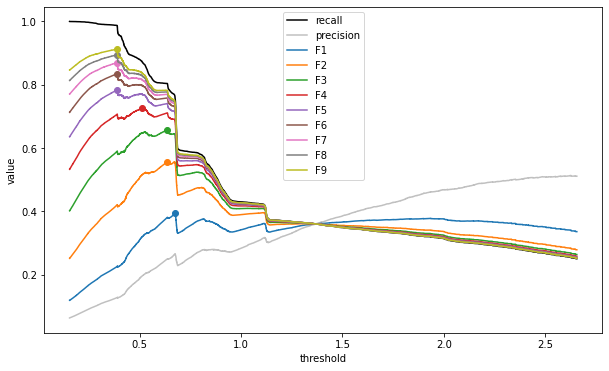

In [19]:
fig = util.plot_fscores(curves_metrics, summary_metrics)

In [20]:
for metric, threshold in zip(summary_metrics.metric, summary_metrics.threshold):
    print(metric, threshold)

F1 0.6728234528091783
F2 0.636936704220479
F3 0.6360641559762945
F4 0.509751909008626
F5 0.3893812768920822
F6 0.3893812768920822
F7 0.3893812768920822
F8 0.3893812768920822
F9 0.3880964725534804


In [21]:
summary_metrics

,metric,value,threshold,precision,recall,FPR
0,F1,0.3932,0.672823,0.2644,0.7667,0.112361
1,F2,0.5566,0.636937,0.2496,0.8037,0.127258
2,F3,0.6578,0.636064,0.2493,0.8041,0.127505
3,F4,0.7256,0.509752,0.1941,0.8754,0.191397
4,F5,0.7842,0.389381,0.1278,0.9871,0.354945
5,F6,0.8353,0.389381,0.1278,0.9871,0.354945
6,F7,0.8701,0.389381,0.1278,0.9871,0.354945
7,F8,0.8945,0.389381,0.1278,0.9871,0.354945
8,F9,0.9123,0.388096,0.1272,0.9875,0.356968


In [50]:
summary_metrics.threshold

0    0.672823
1    0.636937
2    0.636064
3    0.509752
4    0.389381
5    0.389381
6    0.389381
7    0.389381
8    0.388096
Name: threshold, dtype: float64

In [22]:
threshold_b = 0.3880964725534804
y_pred_1 = np.where(score_test < threshold_b, 1, -1)

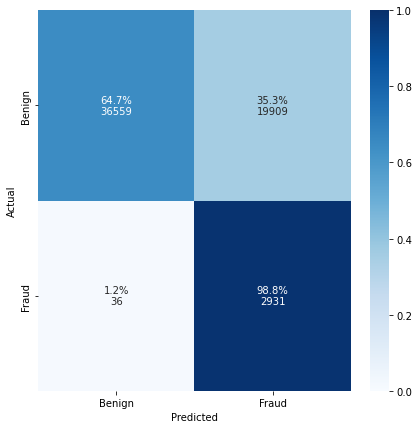

In [23]:
fig = util.plot_confusion_matrix(test['y_n'], y_pred_1, values=[1, -1], labels=["Benign", "Fraud"])

In [28]:
# project = neptune.get_project('verkerken/Two-Stage-Model', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMGJlYTgzNzEtM2U3YS00ODI5LWEzMzgtM2M0MjcyMDIxOWUwIn0=')

In [ ]:
# runs_df = project.fetch_runs_table().to_pandas()
# runs_df['sys/id']

In [ ]:
# runs = project.fetch_runs_table().to_runs()
# for r in runs:
#     print(r['sys/id'].get())

In [140]:
# runs[1]["trials/501/model"].download(destination="/project/Two-Stage/results/full-model/ocsvm.pkl")

In [141]:
# f = open('results/full-model/ocsvm.pkl', 'rb')
# model = pickle.load(f)
# f.close()

In [ ]:
if best_runs_1["algo"][0] == 'ae':
    x_pred = model_1.predict(test['x'])
    

In [44]:
model

Pipeline(steps=[('pca', PCA(n_components=56, random_state=42)),
                ('ocsvm',
                 OneClassSVM(gamma=0.06326539063143335,
                             nu=0.0002316646233151531, verbose=True))])

In [45]:
scores = model.decision_function(val['ocsvm']['x_s']) 

In [46]:
np.unique(val['ocsvm']['y'], return_counts=True)

(array([-1.,  1.]), array([  6820, 129485]))

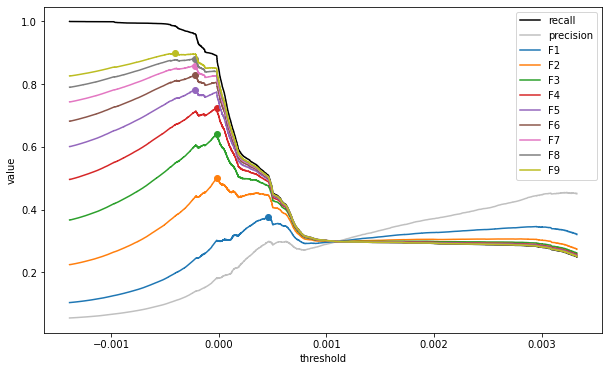

In [47]:
curves_metrics, summary_metrics = util.evaluate_proba(val['ocsvm']['y'], -scores)
fig = util.plot_fscores(curves_metrics, summary_metrics)

In [111]:
np.quantile(-scores[val['ocsvm']['y'] == 1], 0.99)

0.004058861374424127

In [48]:
summary_metrics

,metric,value,threshold,precision,recall,FPR
0,F1,0.3765,0.000457,0.2981,0.5107,0.063328
1,F2,0.5008,-0.000021,0.1821,0.8906,0.210743
2,F3,0.6411,-0.000021,0.1821,0.8906,0.210743
3,F4,0.7247,-0.000021,0.1821,0.8906,0.210743
4,F5,0.7831,-0.000220,0.1393,0.9606,0.312492
5,F6,0.8286,-0.000220,0.1393,0.9606,0.312492
6,F7,0.8593,-0.000220,0.1393,0.9606,0.312492
7,F8,0.8807,-0.000220,0.1393,0.9606,0.312492
8,F9,0.8987,-0.000406,0.1098,0.9861,0.420867


In [63]:
# threshold_b = 0.000056
threshold_b = summary_metrics.loc[summary_metrics['metric'] == 'F9', 'threshold'].values[0]

In [64]:
y_proba_1 = model.decision_function(test['ocsvm_s'])
y_pred = np.where(-y_proba_1 < threshold_b, 1, -1)

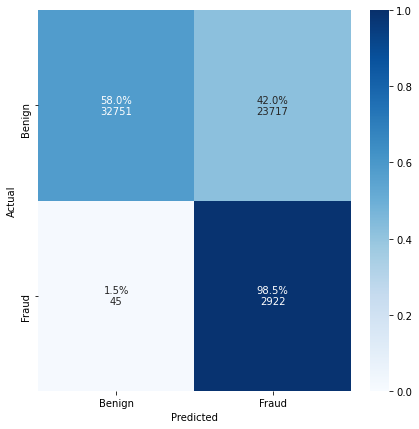

In [65]:
fig = util.plot_confusion_matrix(test['y_n'], y_pred, values=[1, -1], labels=["Benign", "Fraud"])

# Stage 2: Load Model

In [24]:
best_runs_2 = pd.read_csv('results/stage2.csv')
best_runs_2

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_l2,params_n_layer_0,params_n_layer_1,params_n_layer_2,...,user_attrs_f1_macro,user_attrs_f1_weight,state,algo,scaler,run_id,params_max_features,params_max_samples,params_min_samples_leaf,params_n_estimators
0,516,516,0.973737,2021-08-02 14:01:34.796140,2021-08-02 14:01:41.827332,0 days 00:00:07.031192,NaN,NaN,NaN,NaN,...,0.973731,0.973737,COMPLETE,rf,normal,TSM-20,0.211894,0.962158,1.0,88.0
1,488,488,0.973067,2021-08-02 13:58:22.197934,2021-08-02 13:58:28.538663,0 days 00:00:06.340729,NaN,NaN,NaN,NaN,...,0.973034,0.973067,COMPLETE,rf,normal,TSM-20,0.058696,0.840172,1.0,98.0
2,527,527,0.973064,2021-08-02 14:02:50.565703,2021-08-02 14:02:58.119810,0 days 00:00:07.554107,NaN,NaN,NaN,NaN,...,0.973053,0.973064,COMPLETE,rf,normal,TSM-20,0.215225,0.965233,1.0,92.0
3,499,499,0.972736,2021-08-02 13:59:38.862261,2021-08-02 13:59:45.345968,0 days 00:00:06.483707,NaN,NaN,NaN,NaN,...,0.972721,0.972736,COMPLETE,rf,normal,TSM-20,0.079013,0.962928,1.0,89.0
4,481,481,0.972031,2021-08-02 15:23:42.303396,2021-08-02 15:23:48.613821,0 days 00:00:06.310425,NaN,NaN,NaN,NaN,...,0.972031,0.972056,COMPLETE,rf,normal,TSM-21,0.155323,0.977786,1.0,70.0
5,589,589,0.971669,2021-08-02 15:35:17.003645,2021-08-02 15:35:23.207467,0 days 00:00:06.203822,NaN,NaN,NaN,NaN,...,0.971669,0.971725,COMPLETE,rf,normal,TSM-21,0.110134,0.969644,1.0,70.0
6,577,577,0.971566,2021-08-02 15:33:59.129583,2021-08-02 15:34:05.557623,0 days 00:00:06.428040,NaN,NaN,NaN,NaN,...,0.971566,0.971715,COMPLETE,rf,normal,TSM-21,0.173716,0.898387,1.0,65.0
7,442,442,0.971432,2021-08-02 15:19:24.515581,2021-08-02 15:19:30.956510,0 days 00:00:06.440929,NaN,NaN,NaN,NaN,...,0.971432,0.971416,COMPLETE,rf,normal,TSM-21,0.238534,0.939455,1.0,63.0
8,451,451,0.971301,2021-08-02 15:20:26.535597,2021-08-02 15:20:32.854315,0 days 00:00:06.318718,NaN,NaN,NaN,NaN,...,0.971301,0.971375,COMPLETE,rf,normal,TSM-21,0.114950,0.809008,1.0,82.0
9,511,511,0.971033,2021-08-02 14:00:59.357664,2021-08-02 14:01:06.173669,0 days 00:00:06.816005,NaN,NaN,NaN,NaN,...,0.970831,0.971033,COMPLETE,rf,normal,TSM-20,0.175120,0.903413,1.0,97.0


In [25]:
for index, row in best_runs_2.iterrows():
    print(row['number'])

516
488
527
499
481
589
577
442
451
511
451
402
523
403
591
401
446
424
522
414
555
543
529
540
560
205
33
593
43
588


In [26]:
best_runs_2.columns

Index(['Unnamed: 0', 'number', 'value', 'datetime_start', 'datetime_complete',
       'duration', 'params_l2', 'params_n_layer_0', 'params_n_layer_1',
       'params_n_layer_2', 'params_n_layer_3', 'params_n_layer_4',
       'params_n_layer_5', 'params_n_layers', 'user_attrs_accuracy_macro',
       'user_attrs_accuracy_weight', 'user_attrs_balanced_accuracy_macro',
       'user_attrs_balanced_accuracy_weight', 'user_attrs_f1_macro',
       'user_attrs_f1_weight', 'state', 'algo', 'scaler', 'run_id',
       'params_max_features', 'params_max_samples', 'params_min_samples_leaf',
       'params_n_estimators'],
      dtype='object')

In [75]:
row = best_runs_2.iloc[0]
if row['algo'] == "nn":
    model_2 = load_model(f'results/stage2/{row["algo"]}/{row["run_id"]}/models/model_{row["number"]}.h5')
    if row['scaler'] == 'normal':
        y_proba_val_2 = model_2.predict(val['stage2']['x_s'])
        y_proba_test_2 = model_2.predict(test['stage2_s']) 
    else: # 'uniform'
        y_proba_val_2 = model_2.predict(val['stage2']['x_q'])
        y_proba_test_2 = model_2.predict(test['stage2_q']) 
else:
    f = open(f'results/stage2/{row["algo"]}/{row["run_id"]}/models/model_{row["number"]}.p', 'rb')
    model_2 = pickle.load(f)
    f.close()
    y_proba_val_2 = model_2.predict_proba(val['stage2']['x_s'])
    y_proba_test_2 = model_2.predict_proba(test['stage2_s'])


In [58]:
y_proba_val_2

array([[0.96674246, 0.01367491, 0.00615141, 0.00475707, 0.00867407],
       [0.01730174, 0.00192547, 0.01645726, 0.00495208, 0.95936346],
       [0.0052727 , 0.00476378, 0.96764773, 0.00708456, 0.01523131],
       ...,
       [0.88883716, 0.07981645, 0.0086883 , 0.00949714, 0.01316086],
       [0.03418887, 0.00873808, 0.26463374, 0.01533019, 0.6771092 ],
       [0.2095434 , 0.01003241, 0.09987029, 0.00992286, 0.67063105]],
      dtype=float32)

In [63]:
y_proba_test_2

array([[0.58530617, 0.3046808 , 0.06646189, 0.02229097, 0.02126015],
       [0.02075771, 0.00676965, 0.19468199, 0.01115415, 0.7666365 ],
       [0.05763403, 0.88100195, 0.01128945, 0.03917179, 0.01090274],
       ...,
       [0.00830957, 0.97208065, 0.00752776, 0.00638217, 0.00569984],
       [0.97742623, 0.00869735, 0.00404776, 0.00274534, 0.00708334],
       [0.00641845, 0.00795202, 0.00906782, 0.97245365, 0.00410806]],
      dtype=float32)

In [67]:
val['stage2']['y']

array(['(D)DOS', 'Web Attack', 'Brute Force', ..., 'Unknown', 'Unknown',
       'Unknown'], dtype=object)

In [76]:
model_2.classes_

array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack'],
      dtype=object)

In [78]:
train["stage2"]["y_n"].columns

Index(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack'], dtype='object')

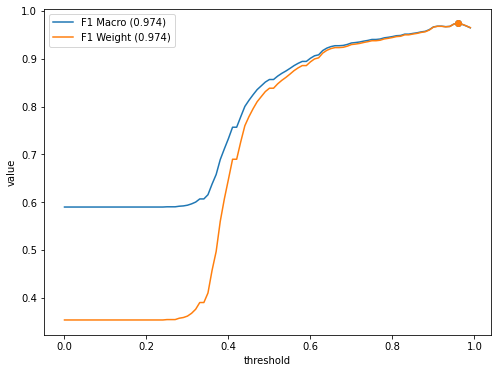

In [52]:
fmacro, fweight, thresholds, f_best = util.optimal_fscore_multi(val['stage2']['y'], y_proba_val_2, model_2.classes_)
fig = util.plot_f_multi(fmacro, fweight, thresholds, f_best)

In [72]:
# Only classify malicious samples from previous stage
# y_proba_2 = model_2.predict_proba(test['stage2_s'][y_pred == -1])
threshold_m = 0.96
y_pred_2 = np.where(np.max(y_proba_test_2, axis=1) > threshold_m, model_2.classes_[np.argmax(y_proba_test_2, axis=1)], 'Unknown')

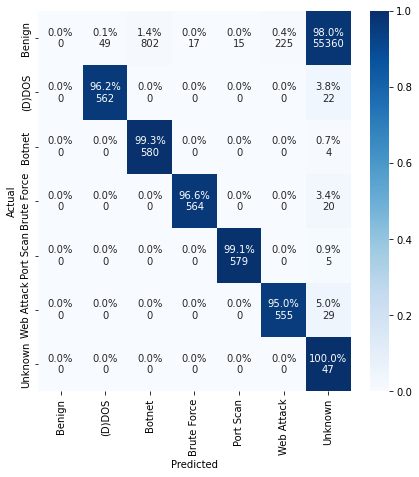

In [73]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
fig = util.plot_confusion_matrix(test['y_unknown'], y_pred_2, values=classes, labels=classes)

In [53]:
f_best

{'f1_macro': 0.973731497200419,
 'f1_macro_threshold': 0.96,
 'f1_weighted': 0.9737370704704673,
 'f1_weighted_threshold': 0.96}

In [151]:
# project = neptune.get_project('verkerken/Stage2-Multi', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMGJlYTgzNzEtM2U3YS00ODI5LWEzMzgtM2M0MjcyMDIxOWUwIn0=')

In [66]:
# runs_df = project.fetch_runs_table().to_pandas()
# runs_df['sys/id']

In [153]:
# runs = project.fetch_runs_table().to_runs()
# runs[2]["trials/390/model"].download(destination="/project/Two-Stage/results/full-model/rf.pkl")

In [68]:
experiment_2 = {
    "nn": "TSM-19", # 22 26 27 28 29 30
    "rf": "TSM-20" # "21"
}

In [76]:
algo_2 = 'rf'
df_2 = pd.read_csv(f'results/stage2/{algo_2}/{experiment_2[algo_2]}/results.csv')
df_2.head(10)

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_max_features,params_max_samples,params_min_samples_leaf,params_n_estimators,user_attrs_accuracy_macro,user_attrs_accuracy_weight,user_attrs_balanced_accuracy_macro,user_attrs_balanced_accuracy_weight,user_attrs_f1_macro,user_attrs_f1_weight,state
0,516,516,0.973737,2021-08-02 14:01:34.796140,2021-08-02 14:01:41.827332,0 days 00:00:07.031192,0.211894,0.962158,1,88,0.973667,0.973667,0.971667,0.971667,0.973731,0.973737,COMPLETE
1,488,488,0.973067,2021-08-02 13:58:22.197934,2021-08-02 13:58:28.538663,0 days 00:00:06.340729,0.058696,0.840172,1,98,0.973000,0.973000,0.970111,0.970111,0.973034,0.973067,COMPLETE
2,527,527,0.973064,2021-08-02 14:02:50.565703,2021-08-02 14:02:58.119810,0 days 00:00:07.554107,0.215225,0.965233,1,92,0.973000,0.973000,0.971000,0.971000,0.973053,0.973064,COMPLETE
3,499,499,0.972736,2021-08-02 13:59:38.862261,2021-08-02 13:59:45.345968,0 days 00:00:06.483707,0.079013,0.962928,1,89,0.972667,0.972667,0.970444,0.970444,0.972721,0.972736,COMPLETE
4,511,511,0.971033,2021-08-02 14:00:59.357664,2021-08-02 14:01:06.173669,0 days 00:00:06.816005,0.175120,0.903413,1,97,0.971000,0.971000,0.963222,0.963222,0.970831,0.971033,COMPLETE
5,583,583,0.970710,2021-08-02 14:09:45.787634,2021-08-02 14:09:52.345969,0 days 00:00:06.558335,0.093396,0.874805,1,94,0.970667,0.970667,0.966222,0.966222,0.970610,0.970710,COMPLETE
6,544,544,0.970062,2021-08-02 14:05:02.477691,2021-08-02 14:05:09.696477,0 days 00:00:07.218786,0.220058,0.933851,1,91,0.970000,0.970000,0.972667,0.971778,0.970179,0.970062,COMPLETE
7,513,513,0.969726,2021-08-02 14:01:14.050908,2021-08-02 14:01:21.096282,0 days 00:00:07.045374,0.193494,0.991383,1,89,0.969667,0.969667,0.970333,0.970333,0.969786,0.969726,COMPLETE
8,560,560,0.969395,2021-08-02 14:07:04.642356,2021-08-02 14:07:11.409173,0 days 00:00:06.766817,0.052556,0.760467,1,81,0.969333,0.969333,0.963556,0.963556,0.969261,0.969395,COMPLETE
9,594,594,0.968997,2021-08-02 14:11:01.359219,2021-08-02 14:11:07.622568,0 days 00:00:06.263349,0.033564,0.945842,1,91,0.968667,0.968667,0.970889,0.970889,0.969286,0.968997,COMPLETE


In [70]:
for index, row in df_2.head(10).iterrows():
    print(row['number'])

516
488
527
499
511
583
544
513
560
594


In [72]:
f = open(f'results/stage2/{algo_2}/{experiment_2[algo_2]}/models/model_516.p', 'rb')
model_2 = pickle.load(f)
f.close()

In [73]:
model_2

RandomForestClassifier(max_features=0.2118936487967764,
                       max_samples=0.9621578085875513, n_estimators=88,
                       random_state=42)

In [155]:
threshold_m = 0.98

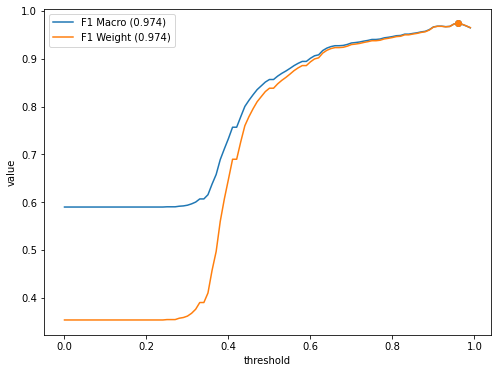

In [74]:
score = model_2.predict_proba(val['stage2']['x_s'])
fmacro, fweight, thresholds, f_best = util.optimal_fscore_multi(val['stage2']['y'], score, model_2.classes_)
fig = util.plot_f_multi(fmacro, fweight, thresholds, f_best)

In [77]:
threshold_m = f_best['f1_weighted_threshold']

In [78]:
# Only classify malicious samples from previous stage
y_proba_2 = model_2.predict_proba(test['stage2_s'][y_pred == -1])
y_pred_2 = np.where(np.max(y_proba_2, axis=1) > threshold_m, model_2.classes_[np.argmax(y_proba_2, axis=1)], 'Unknown')

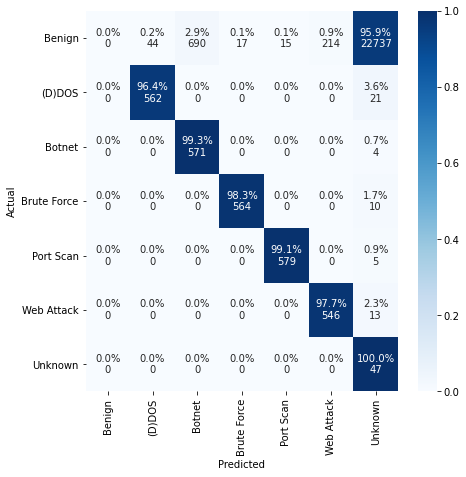

In [79]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
fig = util.plot_confusion_matrix(test['y_unknown'][y_pred == -1], y_pred_2, values=classes, labels=classes)

# Combination Stage 1 & 2

In [150]:
final_pred = np.full(len(test['y_unknown']), "", dtype=object)
final_pred[y_pred == 1] = "Benign"
final_pred[y_pred == -1] = y_pred_2
final_pred

array(['Unknown', 'Benign', 'Benign', ..., 'Botnet', '(D)DOS',
       'Port Scan'], dtype=object)

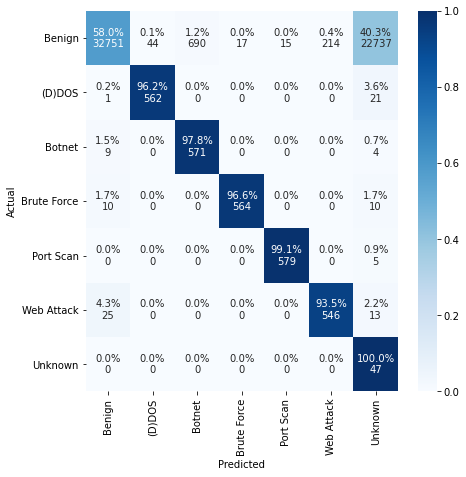

In [151]:
fig = util.plot_confusion_matrix(test['y_unknown'], final_pred, values=classes, labels=classes)

# Extension

In [124]:
(y_pred_2 == 'Unknown').sum()

22837

In [182]:
# threshold_u = summary_metrics.loc[summary_metrics['metric'] == 'F1', 'threshold'].values[0]
threshold_u = np.quantile(-scores[val['ocsvm']['y'] == 1], 0.99)

In [183]:
mask = ((final_pred == "Unknown") & (test['y_unknown_all'] == "Unknown"))

In [184]:
mask.sum()

22784

In [185]:
y_pred_3 = np.where(-y_proba_1[final_pred == "Unknown"] < threshold_u, 'Benign', 'Unknown')

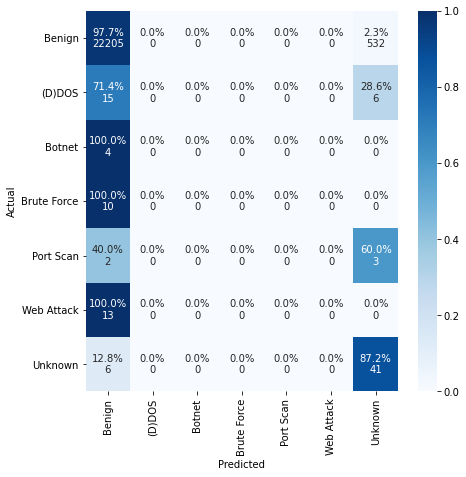

In [186]:
fig = util.plot_confusion_matrix(test['y_unknown'][final_pred == "Unknown"], y_pred_3, values=classes, labels=classes)

In [136]:
y_pred_3 = np.where(-y_proba_1[final_pred == "Unknown"] < threshold_u, 1, -1)

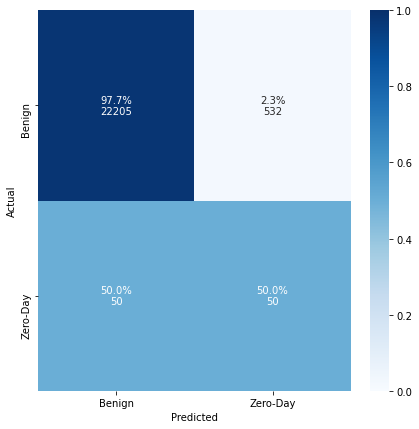

In [137]:
fig = util.plot_confusion_matrix(test['y_n'][final_pred == "Unknown"], y_pred_3, values=[1, -1], labels=["Benign", "Zero-Day"])

In [138]:
y_pred_3 = np.where(-y_proba_1[mask] < threshold_u, 1, -1)

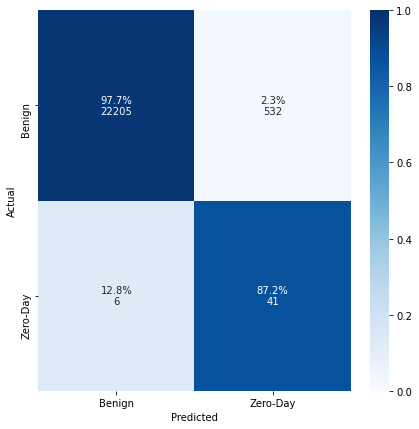

In [139]:
fig = util.plot_confusion_matrix(test['y_n'][mask], y_pred_3, values=[1, -1], labels=["Benign", "Zero-Day"])

# Full Model

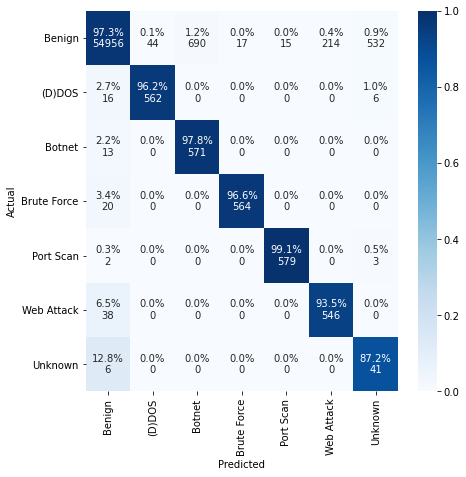

In [141]:
final_pred[final_pred == "Unknown"] = y_pred_3
fig = util.plot_confusion_matrix(test['y_unknown'], final_pred, values=classes, labels=classes)

In [145]:
from sklearn.metrics import f1_score, balanced_accuracy_score
# f1_score(test['y_unknown'], final_pred, average='macro')
balanced_accuracy_score(test['y_unknown'], final_pred)
f1_score(test['y_unknown'], final_pred, average='weighted')

0.9539651398728691

In [149]:
f1_score(test['y_unknown'], final_pred, average='weighted')

0.9790114167539065

# Baseline RF

In [296]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
x_train = np.concatenate((train[]))
